## Mortality Training
1. Load the MIMIC III Dataset
2. Normalize Data
3. Load into Pytorch Dataloader
4. Train
5. Evaluate

In [1]:
import itertools
from os import path

from comet_ml import Experiment
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from core.model import SAnD
from mimic3_benchmarks.mimic3benchmark.readers import InHospitalMortalityReader as Reader
from mimic3_benchmarks.mimic3models.preprocessing import Discretizer, Normalizer
from utils.ihm_utils import evaluate_predictions, load_data, save_results
from utils.functions import get_weights
from utils.trainer import NeuralNetworkClassifier

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
task = "in-hospital-mortality"

comet_ml_info = {
    "api_key": "eQ3INeSsFGUYKahSdEtjhry42",
    "username": "samdoud",
    "project_name": "SAnD-in-hospital-mortality"
}
def get_experiment() -> Experiment:
    return Experiment(
    api_key=comet_ml_info["api_key"],
    project_name=comet_ml_info["project_name"],
    workspace=comet_ml_info["username"],
)

## Load Data
Using the [MimicIII Benchmark's](https://github.com/YerevaNN/mimic3-benchmarks) InHospitalMortalityReader and associated functions, load the data into memory.

If you are following along you will need to arrange the data following the directions on the link.

`Reader` is an alias for `InHospitalMortalityReader` from MIMIC-III Benchmarks


In [2]:
train_reader = Reader(dataset_dir=f"mimic3_benchmarks/data/{task}/train",
                              listfile=f"mimic3_benchmarks/data/{task}/train_listfile.csv")
val_reader = Reader(dataset_dir=f"mimic3_benchmarks/data/{task}/train",
                              listfile=f"mimic3_benchmarks/data/{task}/val_listfile.csv")
test_reader = Reader(dataset_dir=f"mimic3_benchmarks/data/{task}/test",
                              listfile=f"mimic3_benchmarks/data/{task}/test_listfile.csv")

### Example data

In [3]:
ex = pd.DataFrame.from_dict(train_reader.read_example(0)['X'])
ex.columns = train_reader.read_example(0)["header"]
ex

,Hours,Capillary refill rate,Diastolic blood pressure,Fraction inspired oxygen,Glascow coma scale eye opening,Glascow coma scale motor response,Glascow coma scale total,Glascow coma scale verbal response,Glucose,Heart Rate,Height,Mean blood pressure,Oxygen saturation,Respiratory rate,Systolic blood pressure,Temperature,Weight,pH
0,0.2138888888888889,,71.0,,,,,,,94,,95,92.0,16,141.0,,,
1,0.46388888888888885,,71.0,,,,,,,91,,95,93.0,16,141.0,,,
2,0.7138888888888889,,,,,,,,,89,,,93.0,19,,,,
3,0.9638888888888889,,,,,,,,,89,,,94.0,13,,,,
4,1.1305555555555555,,,,,,,,,,,,,,,,,7.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,44.21388888888889,,58.0,,,,,,,103,,81,99.0,21,113.0,,,
67,45.21388888888889,,59.0,,4 Spontaneously,6 Obeys Commands,15,5 Oriented,,107,,81,97.0,22,116.0,,,
68,46.21388888888889,,61.0,,,,,,,100,,85,97.0,20,120.0,,,
69,47.21388888888889,,58.0,,,,,,,90,,83,100.0,18,123.0,37.0,,


### Normalize and Discretize data
From the MIMIC-III Benchmark repo

In [4]:
discretizer = Discretizer(timestep=1.0,
                          store_masks=True,
                          impute_strategy='previous',
                          start_time='zero')

discretizer_header = discretizer.transform(train_reader.read_example(0)["X"])[1].split(',')
cont_channels = [i for (i, x) in enumerate(discretizer_header) if x.find("->") == -1]

In [5]:
normalizer = Normalizer(fields=cont_channels)  # choose here which columns to standardize
normalizer_state = 'train/ihm_ts1.0.input_str-previous.start_time-zero.normalizer'
normalizer.load_params(normalizer_state)

### Load the data into Tensors
The `load_data` method is customized from the MIMIC-III benchmark.

In [6]:
train_raw = load_data(train_reader, discretizer, normalizer)
val_raw = load_data(val_reader, discretizer, normalizer)
# return_names such that the prediction can be tied directly to a patient for evaluation
test_data = load_data(test_reader, discretizer, normalizer, return_names=True)
test_raw = test_data["data"]
test_names = test_data["names"]

N, seq_len, feature_count = train_raw[0].shape

### Load into standard Pytorch datasets

This data has already been collated for us. Shuffle is enabled on the train dataset to limit overfitting. This does come at the cost of reduced determinism.

In [14]:
batch_size = 256

train_ds = TensorDataset(train_raw[0], train_raw[1])
val_ds = TensorDataset(val_raw[0], val_raw[1])
test_ds = TensorDataset(test_raw[0], test_raw[1])

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size)
print(len(test_raw[1]))
print(test_loader.dataset.tensors[1].shape)

3236
torch.Size([3236])


## Create model, Train, and Evaluate
Train the model, this will export results to Comet ML.
Creating is done in the same step such that a new experiment made each time
Evaluation is done in the same step such that the Comet ML experiment is also deleted.

### Paper IHM Module

In [ ]:
n_heads = 8
factor = 12 # M
num_class = 2
num_layers = 4 # N
epochs = 28
betas = (0.9, 0.98)
lr = 5e-4
eps = 4e-09
weight_decay = 5e-4
dropout = 0.3
scores = {}

experiment = get_experiment()

clf = NeuralNetworkClassifier(
    SAnD(feature_count, seq_len, n_heads, factor, num_class, num_layers, dropout_rate=dropout),
    nn.CrossEntropyLoss(),
    optim.Adam, optimizer_config={
        "lr": lr, "betas": betas, "eps": eps, "weight_decay": weight_decay},
    experiment=experiment,
)
# Score is the multiplication of AUPRC and AUROC
score = clf.fit(
    {
        "train": train_loader,
        "val": val_loader
    },
    validation=True,
    epochs=epochs,
    verbose=True,
)

preds = clf.evaluate(test_loader)

experiment.end()

file_path = 'results/test_predictions.csv'
save_results(test_names, preds, test_raw[1], file_path)
pred_df = pd.read_csv(file_path, index_col=False)
list_df = pd.read_csv(f"mimic3_benchmarks/data/{task}/test_listfile.csv", index_col=False)

evaluate_predictions(pred_df, list_df, save_file="results/paper_ihm.json")

clf.save_to_file("results/", "paper-ihm.pth")

### Evaluate
Use the standard MIMIC-III Benchmark evaluation. This exports the stats shown in the paper to a JSON. Presumably, this is the same function the author used.

In [ ]:
file_path = 'results/test_predictions.csv'
save_results(test_names, preds, test_raw[1], file_path)
pred_df = pd.read_csv(file_path, index_col=False)
list_df = pd.read_csv(f"mimic3_benchmarks/data/{task}/test_listfile.csv", index_col=False)

evaluate_predictions(pred_df, list_df)

### Ablation: CrossEntropyLoss weighting

This block searches for the optimal weights to pass `nn.CrossEntropyLoss`.

The weight function is stored in `utils`, but placed here for clarity:
```
def get_weights(labels, level: Optional[int]=1) -> np.array:
    class_sample_count = np.array(
        [len(np.where(labels == t)[0]) for t in np.unique(labels)]
    )
    weight = (1.0 / class_sample_count ** (1/level))
    return weight
```


In [15]:
n_heads = 8
factor = 12 # M
num_class = 2
num_layers = 4 # N
epochs = 12
betas = (0.9, 0.98)
lr = 0.0005
eps = 4e-09
weight_decay = 5e-4
dropout = 0.3
scores = {}

experiment = get_experiment()

for iteration, level in enumerate(np.logspace(0, .75, 30)):
    clf = NeuralNetworkClassifier(
        SAnD(feature_count, seq_len, n_heads, factor, num_class, num_layers, dropout_rate=dropout),
        nn.CrossEntropyLoss(weight=torch.tensor(get_weights(train_raw[1], level=level), dtype=torch.float32).to(device=device)),
        optim.Adam, optimizer_config={
            "lr": lr, "betas": betas, "eps": eps, "weight_decay": weight_decay},
        experiment=experiment,
        silent=True,
    )
    # Score is the multiplication of AUPRC and AUROC
    scores[level] = clf.fit(
        {
            "train": DataLoader(train_ds, batch_size=batch_size, shuffle=False),
            "val": val_loader
        },
        validation=True,
        epochs=epochs,
        verbose=True,
        level=iteration
    )
    print(scores[level])

    #clf.evaluate(test_loader)

experiment.end()
clf.save_to_file("results/", "loss-weighting-ihm.pth")

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/samdoud/general/b4bf309fb70545c6aa87d3d6b8175934



(0.6340095937462535, 0.5864663884855132, 0.7290960042677345)


COMET WARNING: Cannot safely convert (0.6283524102502456, 0.5669025327999752, 0.7512521651507866) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6283524102502456, 0.5669025327999752, 0.7512521651507866)


COMET WARNING: Cannot safely convert (0.6217623921634763, 0.574098734224126, 0.7170897080421769) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6217623921634763, 0.574098734224126, 0.7170897080421769)


COMET WARNING: Cannot safely convert (0.6320160082283492, 0.5730548842643874, 0.7499382561562729) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6320160082283492, 0.5730548842643874, 0.7499382561562729)


COMET WARNING: Cannot safely convert (0.6178481140520711, 0.5539295009779335, 0.7456853402003464) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6178481140520711, 0.5539295009779335, 0.7456853402003464)


COMET WARNING: Cannot safely convert (0.6421928383502372, 0.5829056059779728, 0.7607673030947661) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6421928383502372, 0.5829056059779728, 0.7607673030947661)


COMET WARNING: Cannot safely convert (0.6240889790268777, 0.5756144580224586, 0.7210380210357159) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6240889790268777, 0.5756144580224586, 0.7210380210357159)


COMET WARNING: Cannot safely convert (0.6220815520752839, 0.5784800966410185, 0.7092844629438149) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6220815520752839, 0.5784800966410185, 0.7092844629438149)


COMET WARNING: Cannot safely convert (0.6288233813019399, 0.5708332528969485, 0.7448036381119226) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6288233813019399, 0.5708332528969485, 0.7448036381119226)


COMET WARNING: Cannot safely convert (0.6285921926929029, 0.5657671821945142, 0.7542422136896804) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6285921926929029, 0.5657671821945142, 0.7542422136896804)


COMET WARNING: Cannot safely convert (0.6149044025016279, 0.5505512302268849, 0.7436107470511141) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6149044025016279, 0.5505512302268849, 0.7436107470511141)


COMET WARNING: Cannot safely convert (0.6236890115995066, 0.5620215440330844, 0.7470239467323511) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6236890115995066, 0.5620215440330844, 0.7470239467323511)


COMET WARNING: Cannot safely convert (0.6289165369842625, 0.574212480087984, 0.7383246507768199) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6289165369842625, 0.574212480087984, 0.7383246507768199)


COMET WARNING: Cannot safely convert (0.6223242163773419, 0.5568505243328682, 0.7532716004662895) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6223242163773419, 0.5568505243328682, 0.7532716004662895)


COMET WARNING: Cannot safely convert (0.63095971650158, 0.5676485027475228, 0.7575821440096946) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.63095971650158, 0.5676485027475228, 0.7575821440096946)


COMET WARNING: Cannot safely convert (0.629103653741232, 0.5647503883089179, 0.7578101846058602) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.629103653741232, 0.5647503883089179, 0.7578101846058602)


COMET WARNING: Cannot safely convert (0.6256255283482753, 0.5680456181413334, 0.7407853487621594) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6256255283482753, 0.5680456181413334, 0.7407853487621594)


COMET WARNING: Cannot safely convert (0.6291264880475558, 0.5750855710302172, 0.737208322082233) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6291264880475558, 0.5750855710302172, 0.737208322082233)


COMET WARNING: Cannot safely convert (0.6217216953181838, 0.5644134702216232, 0.7363381455113049) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6217216953181838, 0.5644134702216232, 0.7363381455113049)


COMET WARNING: Cannot safely convert (0.6166150200500178, 0.549908123178157, 0.7500288137937393) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6166150200500178, 0.549908123178157, 0.7500288137937393)


COMET WARNING: Cannot safely convert (0.6062159411647637, 0.5387324221892645, 0.7411829791157623) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6062159411647637, 0.5387324221892645, 0.7411829791157623)


COMET WARNING: Cannot safely convert (0.6090057820020129, 0.5417354062762006, 0.7435465334536377) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6090057820020129, 0.5417354062762006, 0.7435465334536377)


COMET WARNING: Cannot safely convert (0.6143798579389684, 0.5493659597780431, 0.7444076542608192) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6143798579389684, 0.5493659597780431, 0.7444076542608192)


COMET WARNING: Cannot safely convert (0.621757757298843, 0.5596782990475091, 0.7459166738015108) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.621757757298843, 0.5596782990475091, 0.7459166738015108)


COMET WARNING: Cannot safely convert (0.6293801706300879, 0.5767618923710359, 0.7346167271481918) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6293801706300879, 0.5767618923710359, 0.7346167271481918)


COMET WARNING: Cannot safely convert (0.6190779134743193, 0.5531430891172793, 0.7509475621883993) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6190779134743193, 0.5531430891172793, 0.7509475621883993)


COMET WARNING: Cannot safely convert (0.6233031512614262, 0.5713407033010516, 0.7272280471821755) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6233031512614262, 0.5713407033010516, 0.7272280471821755)


COMET WARNING: Cannot safely convert (0.6296186825810423, 0.5747272921658527, 0.7394014634114214) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6296186825810423, 0.5747272921658527, 0.7394014634114214)


COMET WARNING: Cannot safely convert (0.6186103920673649, 0.5558500671805867, 0.7441310418409215) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6186103920673649, 0.5558500671805867, 0.7441310418409215)


COMET WARNING: Cannot safely convert (0.6138143080732188, 0.5465801131632606, 0.7482826978931354) object to a scalar value, using its string representation for logging. Resulting string might be invalid
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/samdoud/general/b4bf309fb70545c6aa87d3d6b8175934
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     AUPRCxAUROC                 : (0.6138143080732188, 0.5465801131632606, 0.7482826978931354)
COMET INFO:     train_AUPRC [20880]         : (0.06640625, 0.7324182205041581)
COMET INFO:     train_AUROC [20880]         : (0.4291202967673556, 0.8382389238553623)
COMET INFO:     train_MSE [20880]           : (0.07552083333333333, 0.8671875)
COMET INFO:     train_accuracy [20880]      : (0.1328125, 0.9244791666666666)
COMET INFO:     train_loss [2262

(0.6138143080732188, 0.5465801131632606, 0.7482826978931354)


COMET INFO: Uploading 1 metrics, params and output messages


In [27]:
results = {level: score for level, score in sorted(scores.items(), key=lambda item: item[1], reverse=True)}
max_level = list(results.keys())[0]
for level, score in results.items():
    print(f"{level}: AUROC/3 + 2/3 * AUPRC {score[0]}; AUPRC {score[1]}; AUROC {score[2]}")

IndexError: list index out of range

### Dropout Optimatization

The author claims that `dropout=0.3 is optimal. However, this is not the case. Anywhere from  ~0.4-~0.7 shows improved performance

In [47]:
n_heads = 8
factor = 12 # M
num_class = 2
num_layers = 4 # N
epochs = 15
betas = (0.9, 0.98)
lr = 4e-5
eps = 4e-09
weight_decay = 4e-5
scores = {}
experiment = get_experiment()

for dropout in np.power(np.arange(0, .96, .02), 2):
    clf = NeuralNetworkClassifier(
        SAnD(feature_count, seq_len, n_heads, factor, num_class, num_layers, dropout_rate=dropout),
        nn.CrossEntropyLoss(weight=torch.tensor(get_weights(train_raw[1], level=max_level), dtype=torch.float32).to(device=device)),
        optim.Adam, optimizer_config={
            "lr": lr, "betas": betas, "eps": eps, "weight_decay": weight_decay},
        experiment=experiment,
        silent=True
    )
    # Score is the multiplication of AUPRC and AUROC
    scores[dropout] = clf.fit(
        {
            "train": DataLoader(train_ds, batch_size=batch_size, shuffle=False),
            "val": val_loader
        },
        validation=True,
        epochs=epochs,
        verbose=False,
        level=iteration
    )
    print(scores[dropout])

    #clf.evaluate(test_loader)

experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/samdoud/general/2b253a1b35724d98b95e6fb5e1fbd71a
COMET INFO:   Uploads:
COMET INFO:     filename           : 1
COMET INFO:     installed packages : 1
COMET INFO:     notebook           : 1
COMET INFO:     source_code        : 1
COMET INFO: ---------------------------
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/samdoud/general/1d39025ecb9149a3a1c3a8859bb3467c

COMET WARNING: Cannot safely convert (0.6126250180647546, 0.5664550952788003, 0.704964863636663) object to a scalar value, using its string representation for logging. Resulting string might be inval

(0.6126250180647546, 0.5664550952788003, 0.704964863636663)


COMET WARNING: Cannot safely convert (0.6051982774145291, 0.5482687768573193, 0.7190572785289489) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6051982774145291, 0.5482687768573193, 0.7190572785289489)


COMET WARNING: Cannot safely convert (0.5595338694741329, 0.48876618484964707, 0.7010692387231044) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.5595338694741329, 0.48876618484964707, 0.7010692387231044)


COMET WARNING: Cannot safely convert (0.601423536686073, 0.5360791066058003, 0.7321123968466184) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.601423536686073, 0.5360791066058003, 0.7321123968466184)


COMET WARNING: Cannot safely convert (0.6065401180199896, 0.5444702071939104, 0.7306799396721483) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6065401180199896, 0.5444702071939104, 0.7306799396721483)


COMET WARNING: Cannot safely convert (0.6000490023789974, 0.5343017384519567, 0.7315435302330789) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6000490023789974, 0.5343017384519567, 0.7315435302330789)


COMET WARNING: Cannot safely convert (0.619910301878853, 0.5617465983888584, 0.7362377088588421) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.619910301878853, 0.5617465983888584, 0.7362377088588421)


COMET WARNING: Cannot safely convert (0.5916951544568141, 0.5228556000901554, 0.7293742631901315) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.5916951544568141, 0.5228556000901554, 0.7293742631901315)


COMET WARNING: Cannot safely convert (0.6111333625196009, 0.557344698902988, 0.718710689752827) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6111333625196009, 0.557344698902988, 0.718710689752827)


COMET WARNING: Cannot safely convert (0.6058522893644491, 0.5474155909978778, 0.7227256860975916) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6058522893644491, 0.5474155909978778, 0.7227256860975916)


COMET WARNING: Cannot safely convert (0.6098935328134186, 0.5521359682599536, 0.7254086619203488) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6098935328134186, 0.5521359682599536, 0.7254086619203488)


COMET WARNING: Cannot safely convert (0.6101110187981291, 0.5424913897263336, 0.7453502769417204) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6101110187981291, 0.5424913897263336, 0.7453502769417204)


COMET WARNING: Cannot safely convert (0.6012870658148268, 0.5528095017564151, 0.6982421939316504) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6012870658148268, 0.5528095017564151, 0.6982421939316504)


COMET WARNING: Cannot safely convert (0.5959496380601323, 0.5292402068745068, 0.7293685004313837) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.5959496380601323, 0.5292402068745068, 0.7293685004313837)


COMET WARNING: Cannot safely convert (0.6005657332012533, 0.5363224138261297, 0.7290523719515005) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6005657332012533, 0.5363224138261297, 0.7290523719515005)


COMET WARNING: Cannot safely convert (0.5978304941506779, 0.5319412963278695, 0.7296088897962948) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.5978304941506779, 0.5319412963278695, 0.7296088897962948)


COMET WARNING: Cannot safely convert (0.6124653139185383, 0.5550810659073458, 0.7272338099409235) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6124653139185383, 0.5550810659073458, 0.7272338099409235)


COMET WARNING: Cannot safely convert (0.6158767194044743, 0.5576856113221793, 0.7322589355690642) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6158767194044743, 0.5576856113221793, 0.7322589355690642)


COMET WARNING: Cannot safely convert (0.6046689103316976, 0.5690167416838515, 0.6759732476273899) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6046689103316976, 0.5690167416838515, 0.6759732476273899)


COMET WARNING: Cannot safely convert (0.6133483612337584, 0.5527174712815405, 0.7346101411381942) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6133483612337584, 0.5527174712815405, 0.7346101411381942)


COMET WARNING: Cannot safely convert (0.611158862749706, 0.5456067517468778, 0.7422630847553626) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.611158862749706, 0.5456067517468778, 0.7422630847553626)


COMET WARNING: Cannot safely convert (0.59436760603877, 0.5276200221103097, 0.7278627738956909) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.59436760603877, 0.5276200221103097, 0.7278627738956909)


COMET WARNING: Cannot safely convert (0.6112450309841446, 0.5525282385341476, 0.7286786158841388) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6112450309841446, 0.5525282385341476, 0.7286786158841388)


COMET WARNING: Cannot safely convert (0.6124740975829468, 0.5488099529894087, 0.7398023867700232) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6124740975829468, 0.5488099529894087, 0.7398023867700232)


COMET WARNING: Cannot safely convert (0.6207835915661793, 0.5664952533898256, 0.7293602679188868) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6207835915661793, 0.5664952533898256, 0.7293602679188868)


COMET WARNING: Cannot safely convert (0.6142471915680819, 0.5733141542521538, 0.6961132661999382) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6142471915680819, 0.5733141542521538, 0.6961132661999382)


COMET WARNING: Cannot safely convert (0.6044941018141281, 0.5401708338924484, 0.7331406376574878) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6044941018141281, 0.5401708338924484, 0.7331406376574878)


COMET WARNING: Cannot safely convert (0.5933721703445733, 0.5248919916944716, 0.730332527644777) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.5933721703445733, 0.5248919916944716, 0.730332527644777)


COMET WARNING: Cannot safely convert (0.6064648135337479, 0.5421048350453811, 0.7351847705104817) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6064648135337479, 0.5421048350453811, 0.7351847705104817)


COMET WARNING: Cannot safely convert (0.6132523982680137, 0.5457327205735796, 0.748291753656882) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6132523982680137, 0.5457327205735796, 0.748291753656882)


COMET WARNING: Cannot safely convert (0.6242448561405217, 0.5627305882802782, 0.7472733918610088) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6242448561405217, 0.5627305882802782, 0.7472733918610088)


COMET ERROR: File-like could not be uploaded: OSError('Could not find a suitable TLS CA certificate bundle, invalid path: c:\\Users\\Samuel\\.conda\\envs\\py38\\lib\\site-packages\\certifi\\cacert.pem')
COMET ERROR: Error sending stdout/stderr batch (online experiment)
COMET ERROR: File-like could not be uploaded: OSError('Could not find a suitable TLS CA certificate bundle, invalid path: c:\\Users\\Samuel\\.conda\\envs\\py38\\lib\\site-packages\\certifi\\cacert.pem')
COMET ERROR: Heartbeat processing error
COMET ERROR: Error sending metrics batch (online experiment)
COMET ERROR: File-like could not be uploaded: OSError('Could not find a suitable TLS CA certificate bundle, invalid path: c:\\Users\\Samuel\\.conda\\envs\\py38\\lib\\site-packages\\certifi\\cacert.pem')
COMET ERROR: File-like could not be uploaded: OSError('Could not find a suitable TLS CA certificate bundle, invalid path: c:\\Users\\Samuel\\.conda\\envs\\py38\\lib\\site-packages\\certifi\\cacert.pem')
COMET ERROR: File-li

(0.6163992844139616, 0.5526536003829373, 0.7438906524760104)


COMET WARNING: Cannot safely convert (0.6200288825060573, 0.5587199638402255, 0.7426467198377208) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6200288825060573, 0.5587199638402255, 0.7426467198377208)


COMET WARNING: Cannot safely convert (0.6085499594223653, 0.549811888954738, 0.7260261003576203) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6085499594223653, 0.549811888954738, 0.7260261003576203)


COMET WARNING: Cannot safely convert (0.6265553303546619, 0.5803253491743858, 0.7190152927152144) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6265553303546619, 0.5803253491743858, 0.7190152927152144)


COMET WARNING: Cannot safely convert (0.6186308863011143, 0.5556465935506724, 0.7445994718019981) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6186308863011143, 0.5556465935506724, 0.7445994718019981)


COMET WARNING: Cannot safely convert (0.6272502598532954, 0.5654987523332076, 0.7507532748934713) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6272502598532954, 0.5654987523332076, 0.7507532748934713)


COMET WARNING: Cannot safely convert (0.610986016952437, 0.5448592950599049, 0.7432394607375014) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.610986016952437, 0.5448592950599049, 0.7432394607375014)


COMET WARNING: Cannot safely convert (0.6090555819511991, 0.5438525925504742, 0.7394615607526491) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6090555819511991, 0.5438525925504742, 0.7394615607526491)


COMET WARNING: Cannot safely convert (0.6342676633910247, 0.5735563387675897, 0.7556903126378945) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6342676633910247, 0.5735563387675897, 0.7556903126378945)


COMET WARNING: Cannot safely convert (0.6306594539522382, 0.5711250173845571, 0.7497283270876004) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6306594539522382, 0.5711250173845571, 0.7497283270876004)


COMET WARNING: Cannot safely convert (0.5934220680054193, 0.5267055448250972, 0.7268551143660635) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.5934220680054193, 0.5267055448250972, 0.7268551143660635)


COMET WARNING: Cannot safely convert (0.6179445924770974, 0.5520712483249641, 0.7496912807813642) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6179445924770974, 0.5520712483249641, 0.7496912807813642)


COMET WARNING: Cannot safely convert (0.5999280093800075, 0.5318011501830798, 0.7361817277738627) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.5999280093800075, 0.5318011501830798, 0.7361817277738627)


COMET WARNING: Cannot safely convert (0.6236457249993475, 0.5596494525055742, 0.751638269986894) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6236457249993475, 0.5596494525055742, 0.751638269986894)


COMET WARNING: Cannot safely convert (0.5861832544939714, 0.5177712627284633, 0.7230072380249873) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.5861832544939714, 0.5177712627284633, 0.7230072380249873)


KeyboardInterrupt: 

In [48]:

results = {level: score for level, score in sorted(scores.items(), key=lambda item: item[1], reverse=True)}
max_level = list(results.keys())[0]
for level, score in results.items():
    print(f"Dropout {level}: AUROC/3 + 2/3 * AUPRC {score[0]}; AUPRC {score[1]}; AUROC {score[2]}")
results

Dropout 0.6084: AUROC/3 + 2/3 * AUPRC 0.6342676633910247; AUPRC 0.5735563387675897; AUROC 0.7556903126378945
Dropout 0.6400000000000001: AUROC/3 + 2/3 * AUPRC 0.6306594539522382; AUPRC 0.5711250173845571; AUROC 0.7497283270876004
Dropout 0.5184: AUROC/3 + 2/3 * AUPRC 0.6272502598532954; AUPRC 0.5654987523332076; AUROC 0.7507532748934713
Dropout 0.4624000000000001: AUROC/3 + 2/3 * AUPRC 0.6265553303546619; AUPRC 0.5803253491743858; AUROC 0.7190152927152144
Dropout 0.36: AUROC/3 + 2/3 * AUPRC 0.6242448561405217; AUPRC 0.5627305882802782; AUROC 0.7472733918610088
Dropout 0.7744: AUROC/3 + 2/3 * AUPRC 0.6236457249993475; AUPRC 0.5596494525055742; AUROC 0.751638269986894
Dropout 0.2304: AUROC/3 + 2/3 * AUPRC 0.6207835915661793; AUPRC 0.5664952533898256; AUROC 0.7293602679188868
Dropout 0.4096: AUROC/3 + 2/3 * AUPRC 0.6200288825060573; AUPRC 0.5587199638402255; AUROC 0.7426467198377208
Dropout 0.0144: AUROC/3 + 2/3 * AUPRC 0.619910301878853; AUPRC 0.5617465983888584; AUROC 0.7362377088588421

{0.6084: (0.6342676633910247, 0.5735563387675897, 0.7556903126378945),
 0.6400000000000001: (0.6306594539522382,
  0.5711250173845571,
  0.7497283270876004),
 0.5184: (0.6272502598532954, 0.5654987523332076, 0.7507532748934713),
 0.4624000000000001: (0.6265553303546619,
  0.5803253491743858,
  0.7190152927152144),
 0.36: (0.6242448561405217, 0.5627305882802782, 0.7472733918610088),
 0.7744: (0.6236457249993475, 0.5596494525055742, 0.751638269986894),
 0.2304: (0.6207835915661793, 0.5664952533898256, 0.7293602679188868),
 0.4096: (0.6200288825060573, 0.5587199638402255, 0.7426467198377208),
 0.0144: (0.619910301878853, 0.5617465983888584, 0.7362377088588421),
 0.4900000000000001: (0.6186308863011143,
  0.5556465935506724,
  0.7445994718019981),
 0.7055999999999999: (0.6179445924770974,
  0.5520712483249641,
  0.7496912807813642),
 0.3844: (0.6163992844139616, 0.5526536003829373, 0.7438906524760104),
 0.11560000000000002: (0.6158767194044743,
  0.5576856113221793,
  0.7322589355690642),


#### Dropout Regression

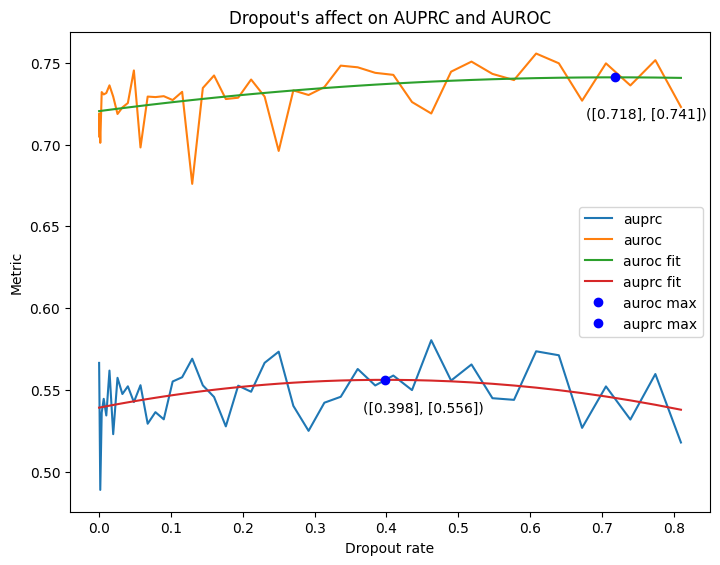

In [38]:
# plot the results from above

%matplotlib inline

#dropout = list(scores.keys())
#auprc = list(score[1] for score in scores.values())
#auroc = list(score[2] for score in scores.values())

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])


coeffecients = np.polyfit(dropout, auroc, 2)
auroc_fit_fn = np.poly1d(coeffecients)
coeffecients = np.polyfit(dropout, auprc, 2)
auprc_fit_fn = np.poly1d(coeffecients)

auroc_deriv = auroc_fit_fn.deriv().r
auroc_max = auroc_deriv[auroc_deriv.imag==0].real
auprc_deriv = auprc_fit_fn.deriv().r
auprc_max = auprc_deriv[auprc_deriv.imag==0].real


ax.plot(dropout, auprc, label="auprc")
ax.plot(dropout, auroc, label="auroc")
ax.plot(dropout, auroc_fit_fn(dropout), label="auroc fit")
ax.plot(dropout, auprc_fit_fn(dropout), label="auprc fit")
ax.plot(auroc_max, auroc_fit_fn(auroc_max),'bo', label="auroc max")
ax.annotate(f"({auroc_max.round(3)}, {auroc_fit_fn(auroc_max).round(3)})",xy=(auroc_max-.04, auroc_fit_fn(auroc_max)-.025))
ax.plot(auprc_max, auprc_fit_fn(auprc_max),'bo', label="auprc max")
ax.annotate(f"({auprc_max.round(3)}, {auprc_fit_fn(auprc_max).round(3)})",xy=(auprc_max-.03, auprc_fit_fn(auprc_max)-.02))

ax.set_title("Dropout's affect on AUPRC and AUROC")
ax.set_xlabel("Dropout rate")
ax.set_ylabel("Metric")
plt.legend()

#### Lock Dropout

In [ ]:
dropout = 0.5

### Vary layers, heads and dense interpolation factor
Since these two parameters are interlinked, we will scan a reasonable set.

High values will cause out of memory exceptions on our 4080 RTX, so this is somewhat limited.

In [ ]:
n_heads = 8
num_class = 2
epochs = 12
betas = (0.9, 0.98)
lr = 4e-5
eps = 4e-09
weight_decay = 4e-5
scores = {}
experiment = get_experiment()

ranges = [
    np.round(np.concatenate((np.arange(1,5), np.linspace(5, 10, 3)),axis=0)),
    np.round(np.linspace(2, 17, 7)),
    np.round(np.linspace(2, 17, 7))
]

for parameters in list(itertools.product(*ranges)):
    num_layers, factors, heads = parameters
    clf = NeuralNetworkClassifier(
        SAnD(feature_count, seq_len, n_heads, factor, num_class, num_layers, dropout_rate=dropout),
        nn.CrossEntropyLoss(weight=torch.tensor(get_weights(train_raw[1], level=max_level), dtype=torch.float32).to(device=device)),
        optim.Adam, optimizer_config={
            "lr": lr, "betas": betas, "eps": eps, "weight_decay": weight_decay},
        experiment=experiment,
        silent=True
    )
    # Score is the multiplication of AUPRC and AUROC
    scores[parameters] = clf.fit(
        {
            "train": DataLoader(train_ds, batch_size=batch_size, shuffle=False),
            "val": val_loader
        },
        validation=True,
        epochs=epochs,
        verbose=False,
        level=iteration
    )
    print(scores[dropout])

    #clf.evaluate(test_loader)

experiment.end()
clf.save_to_file("train/", "model-param-optim.pth")

### Data visualization of results

In [ ]:
best_scores = {parameters: score for parameters, score in sorted(scores.items(), key=lambda item: item[1], reverse=True)}
best_param = next(iter(best_scores))
num_layers, factors, heads = best_param
best_score = best_scores[best_param]

print(f"{num_layers} {factors} {heads} is the best combination leading to a combined AUROC and AUPRC score of {best_score}")

NameError: name 'best_scores' is not defined

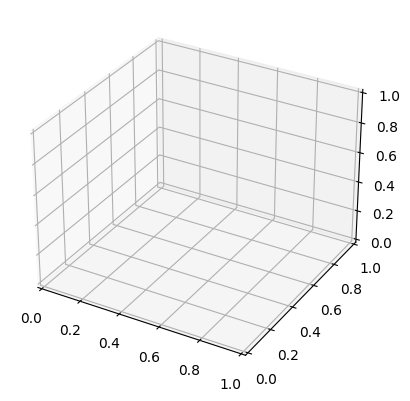

In [39]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

all_num_layers, all_factors, all_heads =  list(zip(*best_scores.keys()))
all_scores = list(best_scores.values())

# Make data.
X = np.array(all_num_layers)
Y = np.array(all_factors)
Z = np.array(all_heads)
X, Y = np.meshgrid(X, Y)
R = np.array(all_scores)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(0, 1)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()